# E2 - Noise Filtration/Reduction

## 1. Introduction
#### Theory background
Noise filtering is fundamental in the image processing for fluorescence microscopy datasets, especially in scenarios where prolonged live cell image acquisitions are desired. In such cases, the excitation power is maintained to be low in order to minimize the photo-bleaching of the fluorophores, in which case the signal to noise ratio is also relevative low due to the lower excitation power. 

In particular, to achieve SOFI movie as demonstrated in our [prior work](https://doi.org/10.1364/BOE.10.002430), the data acquisition conditions need to be controled to maintain a balance between slow photo-bleaching while maintaining the lowest acceptible SNR, and the relevant sample should be those where the semi-static assumption is valid, meaning that the dynamic movement of the feature of interest is slow enough such that when we divide the entire acquired movie into individual time blocks, the feature can be assumed static within the time frame of each block, and be processed with the relevant SOFI processing steps independently. However, such processing step still leave residual imperfections in the resultant images as high frequency noise components, and the results could benefit from further noise filtration to reduce such noises. Since we are working with the sample conditions that are valid under the semi-static assumtpion which suggest that the time evolution of each pixel value along the time axis is slow (low frequency component), while the imperfections (noises) are expected to be random therefore still exist in the high frequency domain in both space and time, therefore we can apply noise filtering along the time-axis for each pixel to remove the high frequency noise componenent. Because the filtration is only applied in the time domain and not applied in the space domain, the spatial resolution of images at each time instance are intact from the filtration.

#### What's included in this notebook
In this notebook, we demonstrate how to use **pysofi** to apply the noise filtration on the SOIF processing results on a series of TIFF stacks as shown in the SOFI 2.0 processing pipeline. The noise filtration step is performed both after the [moment-/cumulant-reconstruction](https://github.com/xiyuyi-at-LLNL/pysofi/blob/master/Notebooks/E1_MomentCumulantReconstructions.ipynb) and after the [shrinking kernel deconvolution](https://github.com/xiyuyi-at-LLNL/pysofi/blob/master/Notebooks/E3_ShrinkingKernelDeconvolution.ipynb), but please note that this step can be applied in different scenarios independent of SOFI 2.0.


#### Relevant dataset
The datafiles used in the examples (Jupyter Notebooks) are included in the *exampledata* folder in the **pysofi** repository. In this notebook, we use an experimental dataset from our previous work [1]. The sample is a Hela cell transfected with Dronpa-C12 (fluorescent protein) fused to β-Actin. Details of the experimental procedure are availble in the relevant pulbication [1]. We used 20 blocks of tiff videos ('Block1.tif' to 'Block20.tif') in this demonstration, each block contains 200 frames and is SOFI processed independently. The input data can be replaced with any datasets with the same format (tiff image stacks), which can either be simulations or experimental acquisitions. 


## 2. Import all the tools
Before we begin, let's first import all the relevant packages and modules.

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from pysofi import pysofi, filtering, masks
%matplotlib inline
%load_ext autoreload
%autoreload 2

## 3. Load data blocks into seperate PysofiData objects.
First, we generate a list of filenames to specify the data sets to be used in this demonstration

In [2]:
filenum = 20
filepath = '../sampledata'
filenames = ['Block' + str(i+1) + '.tif' for i in range(filenum)]

Second, we load the list of datasets specified in the list above into a aseries of *PysofiData* objects, and organize them into a dictionary for which every element specifies one *PysofiData* object corresponds to one TIFF file. 

In [3]:
# initialize the empty dictionary to hold all the relevant PysofiData objects for each datafile
dset = {} 

# generate the dictionary of PysofiData objects responsible for the SOFI processing for each dataset.
for filename in filenames:
    dset[filename] = pysofi.PysofiData(filepath, filename)

The keys for the elements in the *dset* dictionary are the filenames (e.g. 'Block1.tif' for the first element), and the values are the corresponding PysofiData object specified to perform SOFI processing for each dataset specified by the filename if each element. The script above is using the *PysofiData* to perform the relevant SOFI processing steps independently for each TIFF file. The *dset* dictionary is an input parameter for the noise filtration step (explained in section 5).

## 4. Calculate the moment-mages for all the time blocks.
In SOFI 2.0 processing, the first noise filtration step is perfromed after calculating the *moment* images for each block of TIFF images. Therefore, here we first calculate the *moment* images for the series of TIFF stacks. Details of the moment- and cumulant-calculations for a single TIFF stack are available in [E1](https://github.com/xiyuyi-at-LLNL/pysofi/blob/master/Notebooks/E1_MomentCumulantReconstructions.ipynb). Here we loop over all the *PysofiData* objects to perfrom the calculations for all the TIFF stacks:

In [4]:
# prepare an empty dictionary to store the resultant moment images for each stack.
m_set = {}

# loop over all the PysofiData objects to perfrom 6th order moments calculations for each TIFF stack, 
# and store the returend moment image into the dictionar m_set, where the keys are the filenames, 
# and the values are the images.
for filename in filenames:
    print('\n' + 'Calculating ' + filename + '...')
    m_set[filename] = dset[filename].moment_image(order=6, finterp=False)


Calculating Block1.tif...
Calculating the 6-order moment ...
[==============================] 100.0%


Calculating Block2.tif...
Calculating the 6-order moment ...
[==============================] 100.0%


Calculating Block3.tif...
Calculating the 6-order moment ...
[==============================] 100.0%


Calculating Block4.tif...
Calculating the 6-order moment ...
[==============================] 100.0%


Calculating Block5.tif...
Calculating the 6-order moment ...
[==============================] 100.0%


Calculating Block6.tif...
Calculating the 6-order moment ...
[==============================] 100.0%


Calculating Block7.tif...
Calculating the 6-order moment ...
[==============================] 100.0%


Calculating Block8.tif...
Calculating the 6-order moment ...
[==============================] 100.0%


Calculating Block9.tif...
Calculating the 6-order moment ...
[==============================] 100.0%


Calculating Block10.tif...
Calculating the 6-order moment ...
[=========

Similar to *dset*, the keys for the elements in the *m_set* dictionary are the filenames (e.g. 'Block1.tif' for the first element), and the values are the corresponding *moment* image calculated for the specified dataset. This *mset* dictionary is also an input parameter for the noise filtration step shown in section 5.

## 5. Noise Filtration on *moment* images

The noise filtration step is perfromed indepedent of the SOFI processing steps, therefore it is not a data processing step within the SOFI processing pipeline and is not organized in the *PysofiData* class. The only option to perfrom such noise filtration is through importing the relevant function module <code>filtering.py</code> and use the <code>filtering.noise_filter2d</code> function.

First, we need to prepare the dictionary of PysofData objects to specifiy the independent analysis proccesses for each individual TIFF stack as shown in section 3 above (*dset*), and prepare the dictionary of images to be filtered as shown above in section 4 (*m_set*).



Second, we need to generate a one-dimensional Gaussian mask with a defined shape and $\sigma$ by calling the function <code>masks.gauss1D_mask</code>:


In [5]:
# generate a noise filter as a 1D guasisan profile:
nf = masks.gauss1d_mask(shape = (1,21), sigma = 2)

Note that the type of the *nf* variable is numpy.ndarray, other filters could be used as long as the filter varialbe is kept in the same format.

Third, we can perfrom the noise filtration using the following command:

In [6]:
m_filtered_set = filtering.noise_filter1d(dset, m_set, nf, return_option=True, return_type='dict')

Noise filtering ...
[====================] 100%

The filtration is essentially performed by taking the convolution of the time series of each pixel in the images specified in *m_set* (across all the elements in the *m_set* dictionary) with a 1-dimensional convolution kernel specified by *nf*. 

The returned value *m_filtered* is in the same format of *m_set* as a dictionary, where the key for each element is the corresponding file name, and the value of each element are the images after noise filtration. The noise filtration operation also modifies all the *PysofiData* objects specified in the *dset* dictionary, where the noise filtered results are appended to the *PysofiData* object as the *PysofiData.filtered* attribute.


The parameters for function <code>filtering.noise_filter1d</code> include the following:
+ <code>dset</code>: a dictionary of PysofiData objects defined upon loading the data.
+ <code>im_set</code>: a dictionary of images to be filtered. In our case, the dictionary keys are filenames and the dictionary values are the moment images.
+ <code>noise_filter</code>: The filter function. The default is a 1D Gaussian profile with $shape = (1, 21)$ and $\sigma = 2$.
+ <code>filtername</code>: name of the filtered image that add to the PysofiData object as an attribute.
+ <code>filenames</code>: keys (filenames) in im_set. The user can define the correct sequence.
+ <code>return_option</code>: besides add filtered images to PysofiData objects, whether to return them in a 3D array.
+ <code>return_type</code>: type of returned variable. (choose 'ndarray', or 'dict')

Please note that in the demonstration above, we chose the return type to be 'dict', the keys are the same for the following dictionaries: *dset*, *m_set*, and *m_filered*:

In [7]:
print('\n Keys for m_set:')
print([*m_set])

print('\n Keys for dset')
print([*dset])

print('\n Keys for m_filtered')
print([*m_filtered_set])


 Keys for m_set:
['Block1.tif', 'Block2.tif', 'Block3.tif', 'Block4.tif', 'Block5.tif', 'Block6.tif', 'Block7.tif', 'Block8.tif', 'Block9.tif', 'Block10.tif', 'Block11.tif', 'Block12.tif', 'Block13.tif', 'Block14.tif', 'Block15.tif', 'Block16.tif', 'Block17.tif', 'Block18.tif', 'Block19.tif', 'Block20.tif']

 Keys for dset
['Block1.tif', 'Block2.tif', 'Block3.tif', 'Block4.tif', 'Block5.tif', 'Block6.tif', 'Block7.tif', 'Block8.tif', 'Block9.tif', 'Block10.tif', 'Block11.tif', 'Block12.tif', 'Block13.tif', 'Block14.tif', 'Block15.tif', 'Block16.tif', 'Block17.tif', 'Block18.tif', 'Block19.tif', 'Block20.tif']

 Keys for m_filtered
['Block1.tif', 'Block2.tif', 'Block3.tif', 'Block4.tif', 'Block5.tif', 'Block6.tif', 'Block7.tif', 'Block8.tif', 'Block9.tif', 'Block10.tif', 'Block11.tif', 'Block12.tif', 'Block13.tif', 'Block14.tif', 'Block15.tif', 'Block16.tif', 'Block17.tif', 'Block18.tif', 'Block19.tif', 'Block20.tif']


If we set the <code>return_type='ndarray'</code>, the returned value will be in the format of a ndarray.

#### Now let's look at the results

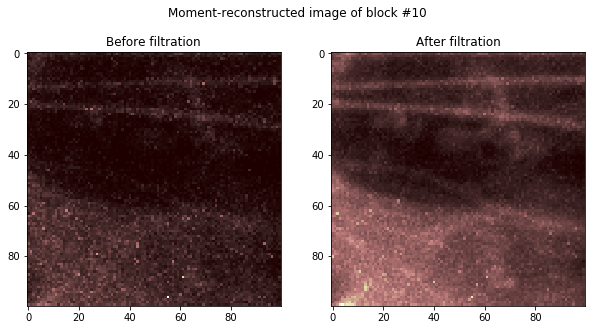

In [8]:
# Show images of block 10 before and after the filtration
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Moment-reconstructed image of block #10")
axs[0].set_title('Before filtration')
axs[0].imshow(m_set['Block10.tif'][100:200, 100:200], cmap='pink')

axs[1].set_title('After filtration')
axs[1].imshow(m_filtered_set['Block9.tif'][100:200, 100:200], cmap='pink')
plt.show() 

We can see the enhancement in the image after the noise filtration.

#### Noise filtration on average images for the blocks
As mentioned before, the user can add in the noise filtration step any time throughout the image analysis pipeline. Besides moment-reconstructed images, here we can also filter on the average image of each block.

First, we calculate the average image for each time block, and assign it to dictionary <code>ave_im_set{}</code> in the format of input parameter <code>im_set</code> of the <code>filtering.noise_filter1d</code> function:

In [9]:
#calcualte average image for each time block
ave_im_set = {}
for filename in filenames:
    print('\n' + 'Calculating ' + filename + '...')
    ave_im_set[filename] = dset[filename].average_image()


Calculating Block1.tif...

Calculating Block2.tif...

Calculating Block3.tif...

Calculating Block4.tif...

Calculating Block5.tif...

Calculating Block6.tif...

Calculating Block7.tif...

Calculating Block8.tif...

Calculating Block9.tif...

Calculating Block10.tif...

Calculating Block11.tif...

Calculating Block12.tif...

Calculating Block13.tif...

Calculating Block14.tif...

Calculating Block15.tif...

Calculating Block16.tif...

Calculating Block17.tif...

Calculating Block18.tif...

Calculating Block19.tif...

Calculating Block20.tif...


Next, we define a Gaussian filter, and perform the noise filtration:

In [10]:
nf = masks.gauss1d_mask(shape = (1,21), sigma = 1.5)
ave_im_filtered = filtering.noise_filter1d(dset, ave_im_set, nf, return_option=True)

Noise filtering ...
[====================] 100%

Now we can check the results:

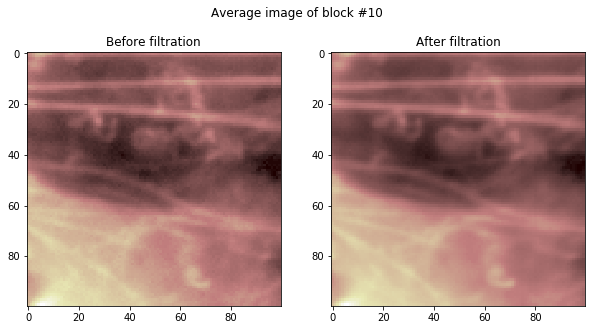

In [11]:
# Show images of block 10 before and after the filtration
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Average image of block #10")
axs[0].set_title('Before filtration')
axs[0].imshow(ave_im_set['Block10.tif'][100:200, 100:200], cmap='pink')

axs[1].set_title('After filtration')
axs[1].imshow(ave_im_filtered['Block9.tif'][100:200, 100:200], cmap='pink')
plt.show() 

We can also compare such filtration to the single-image noise filtration to see the difference:

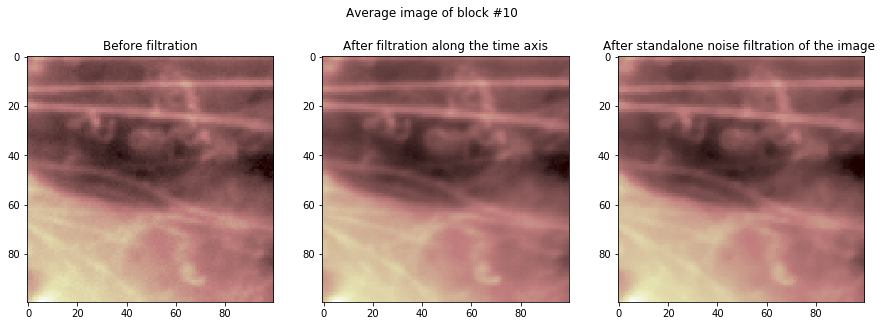

In [12]:
from scipy import ndimage
im_med = ndimage.median_filter(ave_im_set['Block10.tif'], 3)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Average image of block #10")
axs[0].set_title('Before filtration')
axs[0].imshow(ave_im_set['Block10.tif'][100:200, 100:200], cmap='pink')

axs[1].set_title('After filtration along the time axis')
axs[1].imshow(ave_im_filtered['Block9.tif'][100:200, 100:200], cmap='pink')

axs[2].set_title('After standalone noise filtration of the image ')
axs[2].imshow(im_med[100:200, 100:200], cmap='pink')
plt.show() 